In [1]:
#|default_exp distances
from diffusion_curvature.utils import *

# Manifold Distances

Here we provide reimplementations of algorithms for estimating the manifold distances of a graph.

## PHATE Distances

Wasserstein Diffusion Curvature -- despite the name -- requires only manifold distances. This saves quite a bit of computation, but doesn't alleviate the need for a good approximation of the manifold's geodesic distance. Here, we implement one straightforward and accurate manifold distance: that proposed by Moon et al. in PHATE (2019). The PHATE distance is an extension of the diffusion distance, except instead of calculating the L2 distances between diffusion coordinates (which corresponds roughly to the rows of the diffusion matrix), it takes the L2 distances between the log-transformed diffusions. This flips the weighting from local to global, as a diffusion that assigns a small mass where another assigns a miniscule mass becomes much further than those that differ only at their centers. This log transform has the additional advantage of, through the WAWA formulation of the heat equation, recovering the distance term.

It is defined as:
$$d_p(x,y) = \| \log(p_y^t)-\log(p_x^t) \|_2 $$

In [2]:
#|export
from sklearn.metrics import pairwise_distances
import numpy as np
import scipy
import graphtools

def phate_distances_graphtools(G:graphtools.api.Graph):
    assert G.Pt is not None
    if type(G.Pt) == np.ndarray:
        log_Pts = -np.log(G.Pt + 1e-6)
        D = pairwise_distances(log_Pts)
    elif type(G.Pt) == scipy.sparse.csr_matrix:
        # TODO: There's likely a more efficient way of doing this. 
        # But I mustn't tempt the devil of premature optimization
        Pt_np = G.Pt.toarray()
        log_Pts = -np.log(Pt_np + 1e-6)
        D = pairwise_distances(log_Pts)
    G.D = D
    return G

In [3]:
#|export
import jax.numpy as jnp
def pairwise_euclidean(x, y):
  # Pairwise euclidean distances in Jax, courtesy of [jakevdp](https://github.com/google/jax/discussions/11841)
  assert x.ndim == y.ndim == 2
  return jnp.sqrt(((x[:, None, :] - y[None, :, :]) ** 2).sum(-1)) # I would want to use something like PyKeops for this, if being done differentiably.
  
def phate_distances(Pt):
    log_Pts = -jnp.log(Pt + 1e-6)
    D = pairwise_distances(log_Pts, log_Pts)
    return D

def phate_distances_differentiable(Pt):
    return phate_distances(Pt)

In [5]:
#|export
from diffusion_curvature.graphs import get_adaptive_graph
from sklearn.preprocessing import normalize
from diffusion_curvature.heat_diffusion import jax_power_matrix
def phate_distances_from_pointcloud(X, t = 25):
    G = get_adaptive_graph(X)
    P = normalize(G.W, norm="l1", axis=1)
    if type(P) == scipy.sparse._csr.csr_matrix:
        P = P.todense()
    # diffusion_matrix_from_affinities(G.W)
    # P = diff_op(G).todense() # is sparse, by default
    P = jnp.array(P)
    Pt = jax_power_matrix(P,t)
    return phate_distances(Pt)
    

In [6]:
A = random_jnparray(8,3)
D = pairwise_euclidean(A,A)

In [7]:
D.shape

(8, 8)

In [8]:
from diffusion_curvature.datasets import torus
import graphtools

In [12]:
X_torus, ks_torus = torus(2000)

In [13]:
D = phate_distances_from_pointcloud(X_torus)

2024-03-24 16:34:50,781:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


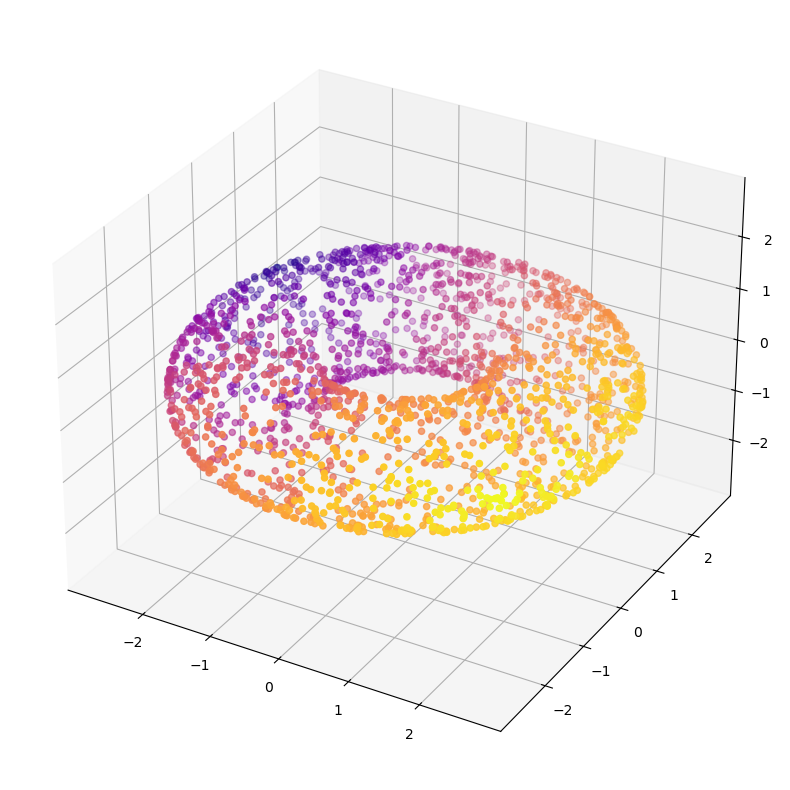

In [16]:
plot_3d(X_torus,D[0])

In [ ]:
!nbdev_export